## Измерить сечение

In [1]:
%load_ext autoreload
%autoreload 2

In [410]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylib.style as pys

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [318]:
def get_x(df, phi):
    mKs= 497.6
    p0 = np.sqrt(df.emeas.mean()**2 - mKs**2)
    dE = df.ksminv - mKs
    dP = df.ksptot - p0
    x1 =  dE*np.cos(phi) - dP*np.sin(phi)
    x2 =  dE*np.sin(phi) + dP*np.cos(phi)
    return x1, x2

In [299]:
dfExp = uproot.open('../trees/19/exp.root')['t'].pandas.df()
dfMC  = uproot.open('../trees/19/mc_mcgpj2.root')['t'].pandas.df()

dfExp['ebeam'] = dfExp.name.astype(str).str.extract(r'_e(\d+.?\d*)_', expand=False).astype(float)
dfMC['ebeam'] = dfMC.name.astype(str).str.extract(r'_(\d+.?\d*)_', expand=False).astype(float)
dfMC['runnum'] = dfMC.name.astype(str).str.extract(r'_(\d+).root', expand=False).astype(int)

dfExp.drop('name', axis=1, inplace=True)
dfMC.drop('name', axis=1, inplace=True)

dfExp = dfExp.set_index('ebeam')
dfMC = dfMC.set_index('ebeam')

In [372]:
dfMC.head()

,runnum,emeas,trigbits,tth[0],tth[1],tz[0],tz[1],tptot[0],tptot[1],trho[0],...,tchi2r[1],tchi2z[0],tchi2z[1],tnhit[0],tnhit[1],ksminv,ksptot,ksalign,kslen,sim_energy
ebeam,,,,,,,,,,,,,,,,,,,,,
537.5,70914,537.453979,1,2.005805,0.816097,0.241445,-0.888369,143.569092,311.319489,-1.844756,...,1.170788,0.991979,0.694018,20,9,499.395172,216.374481,0.999027,2.772172,9.248684e-26
537.5,70914,537.453979,1,2.100847,1.231824,0.373388,1.236971,163.939804,266.816101,0.329661,...,0.386262,0.529379,2.069548,20,13,505.448303,115.481873,0.993188,1.221455,5.417330e-02
537.5,70914,537.453979,3,1.064023,2.009341,0.545712,0.701725,207.671967,250.174591,0.497540,...,1.026735,0.957598,2.091434,21,16,497.253052,201.719330,0.996737,0.513309,3.772817e-04
537.5,70914,537.453979,3,1.970497,1.382862,-1.777212,-1.631636,237.645996,216.820862,-0.814446,...,0.688015,1.209268,1.051637,16,17,497.766693,194.066284,0.999999,0.949363,2.066458e-10
537.5,70914,537.453979,1,2.077082,0.747478,-3.668395,-3.670606,234.502472,192.621414,0.318320,...,0.258133,0.670550,1.641627,15,11,496.693756,116.323097,0.992242,0.680561,5.535079e-02


In [361]:
for i in sorted( dfExp.index.unique() & dfMC.index.unique()):
    print(i, end=' ')

537.5 550.0 562.5 575.0 587.5 600.0 612.5 625.0 637.5 641.0 650.0 662.5 675.0 687.5 700.0 712.5 725.0 737.5 750.0 762.0 775.0 787.5 800.0 812.5 825.0 837.5 850.0 862.5 875.0 887.5 900.0 912.5 925.0 936.0 945.0 950.0 951.1 955.0 962.5 975.0 978.0 987.5 

In [457]:
e0, nMC = 537.5, 20000

In [458]:
dfE = dfExp.loc[e0].copy()
dfM =  dfMC.loc[e0].copy()
assert dfM.runnum.nunique()==1

phi =  0.205/(e0*2e-3-0.732) + 0.14

x1, x2 = get_x(dfE, phi)
dfE = dfE.assign(x1=x1, x2=x2)
x1, x2 = get_x(dfM, phi)
dfM = dfM.assign(x1=x1, x2=x2)

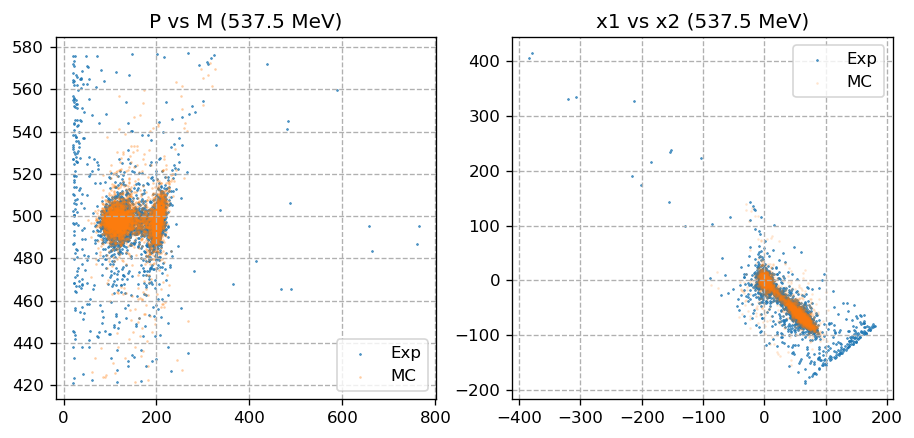

In [459]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))

ax1.scatter(dfE.ksptot, dfE.ksminv, marker='.', s=1, label='Exp');
ax1.scatter(dfM.ksptot, dfM.ksminv, marker='.', s=1, alpha=0.4, label='MC');
ax1.set_title(f'P vs M ({e0} MeV)');
ax1.grid(ls='--')
ax1.legend();
# plt.plot([750, 900], [460+(750-750)*np.tan(phi), 460+(900-750)*np.tan(phi)])
# # plt.xlim(0, 250)

ax2.scatter(dfE.x1, dfE.x2, marker='.', s=1, label='Exp');
ax2.scatter(dfM.x1, dfM.x2, marker='.', s=1, alpha=0.2, label='MC');
ax2.set_title(f'x1 vs x2 ({e0} MeV)');
ax2.grid(ls='--')
ax2.legend();
# plt.ylim(-100, 300)

<AxesSubplot:>

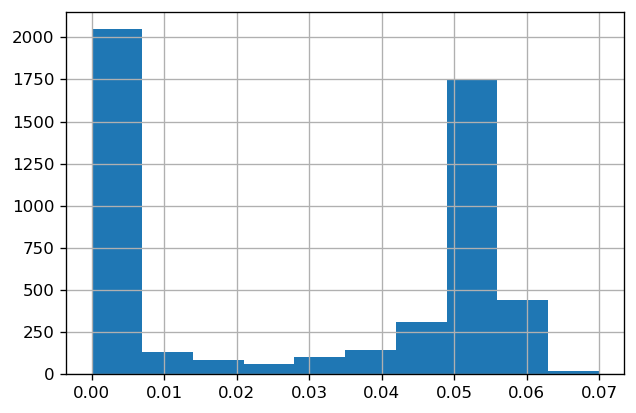

In [460]:
dfM.sim_energy.hist()

In [463]:
dfM_soft = dfM.loc[dfM.sim_energy < 0.02]
dfM_hard = dfM.loc[dfM.sim_energy >= 0.02]

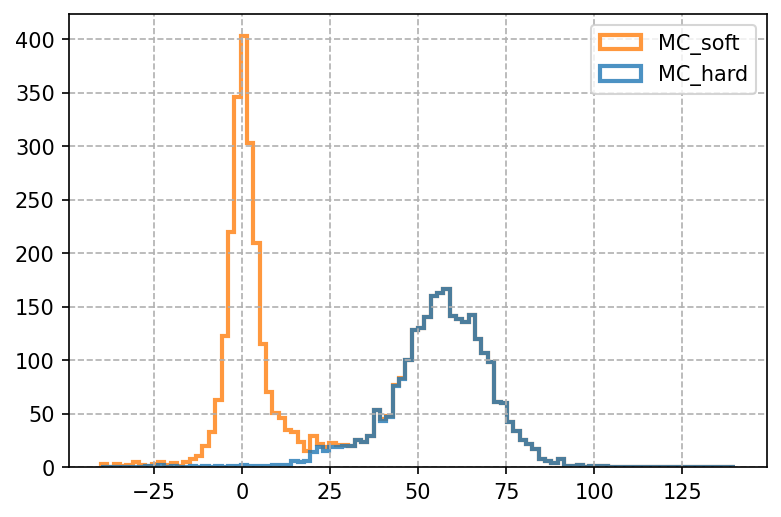

In [464]:
plt.figure(dpi=150)
plt.grid(ls='--')
hist_range, hist_bins, hist_norm = (-40, 140), 100, 7

count_exp = np.count_nonzero(abs(dfE.x1)<hist_norm)
count_mc  = np.count_nonzero(abs(dfM.x1)<hist_norm)

# pys.hep_histo(dfE.x1, bins=hist_bins, range=hist_range, label='Exp')
# plt.hist(dfE.x1, bins=hist_bins, range=hist_range, histtype='step', density=False, lw=2, label='Exp', alpha=1);
# plt.hist(dfM.x1, bins=hist_bins, range=hist_range, histtype='step', density=False, lw=2, label='MC', 
#          weights=np.ones(len(dfM))*count_exp/count_mc, alpha=0.8);
plt.hist([dfM_hard.x1, dfM_soft.x1], bins=hist_bins, range=hist_range, histtype='step', density=False, lw=2, 
         label=['MC_hard', 'MC_soft'], stacked=True, alpha=0.8, zorder=0,
         weights=[np.ones(len(dfM_hard))*count_exp/count_mc, np.ones(len(dfM_soft))*count_exp/count_mc]);
# plt.yscale('log')
plt.legend();

Fit

In [465]:
import numba as nb
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL, BinnedNLL, ExtendedUnbinnedNLL, ExtendedBinnedNLL, LeastSquares
from argparse import Namespace

In [533]:
hist_range = (-40, 50)
width = hist_range[1] - hist_range[0]
dt = dfM.x1.values
dt = dt[(dt>hist_range[0])&(dt<hist_range[1])]

In [566]:
kwd = {"parallel": False, "fastmath": True}

@nb.njit(**kwd)
def signal_pdf(x, mu, sigma):
    z = (x - mu) / sigma
    invnorm = 1 / ( np.sqrt(2 * np.pi) * sigma )
    signal = np.exp(-(z**2)/2) * invnorm
    return signal

@nb.njit(**kwd)
def norm_pdf(x, mu1, mu2, sigma1, sigma2, f, fs):
    sig1 = signal_pdf(x, mu1, sigma1)
    sig2 = signal_pdf(x, mu2, sigma2)
    bkg = 1/width
    return f*( fs*sig1 + (1-fs)*sig2 ) + (1-f)*bkg

In [3]:
m = Minuit(ExtendedUnbinnedNLL(dt, lambda x, n, mu1, mu2, sigma1, sigma2, f, fs: (n, n * norm_pdf(x, mu1, mu2, sigma1, sigma2, f, fs))),
                       n=1000, mu1=0, mu2=1, sigma1=2, sigma2=5, f=0.99,
                       limit_mu1=(-2, 2),
                       limit_mu2=(-12, 12),
                       limit_sigma1=(0,None),
                       limit_sigma2=(0,None),
                       limit_n=(0, None),
                       limit_f=(0, 1),
                       limit_fs=(0, 1),
          )

NameError: name 'Minuit' is not defined

In [2]:
m.migrad()

NameError: name 'm' is not defined

In [ ]:
pys.plot_fit(dt, norm_pdf, m, 80, hist_range, errors=True, label='Experiment', xtitle='x1 distribution',
           ytitle='number of events per bin')
# plt.savefig('pic3.png')

In [74]:
from pylib.radcors import RadCor

In [75]:
cs_approx = pd.read_csv('../data/cross_sections_kskl.txt', header=None, sep=' ')[[1, 2]]
cs_approx[1] /= 2

In [76]:
cs_approx

,1,2
0,497.5,0.000000
1,498.0,0.067593
2,498.5,0.292279
3,499.0,0.642567
4,499.5,1.128050
...,...,...
550,1046.0,0.368000
551,1047.0,0.381000
552,1048.0,0.394000
553,1049.0,0.409000


In [77]:
r = RadCor(cs_approx[1], cs_approx[2])

In [78]:
r.F_Radcor(1059.947/2)

(1.8978407634915915, 1.3592433366270849e-05)

In [44]:
np.extract(r.y>1000, r.y)

array([1009.83788297, 1042.80429893, 1074.80668805, 1105.84505034,
       1135.91938579, 1165.02969441, 1193.1759762 , 1220.35823115,
       1246.57645926, 1271.10635807, 1291.33171835, 1307.01606621,
       1318.15940165, 1324.76172467, 1326.82303528, 1324.34333347,
       1317.32261923, 1305.76089258, 1289.65815351, 1269.01440203,
       1243.82963812, 1214.10386179, 1179.83707305, 1141.02927189,
       1097.68045831, 1049.79063231])

In [45]:
np.extract(r.y>1000, r.x)

array([509.02958296, 509.08582858, 509.14207421, 509.19831983,
       509.25456546, 509.31081108, 509.36705671, 509.42330233,
       509.47954795, 509.53579358, 509.5920392 , 509.64828483,
       509.70453045, 509.76077608, 509.8170217 , 509.87326733,
       509.92951295, 509.98575858, 510.0420042 , 510.09824982,
       510.15449545, 510.21074107, 510.2669867 , 510.32323232,
       510.37947795, 510.43572357])

In [10]:
# dfExp = uproot.open('../trees/exp2019.root')['t'].pandas.df()
dfMC  = uproot.open('../trees/19/mc_mcgpj.root')['t'].pandas.df()

In [8]:
dfExp = uproot.open('../trees/exp2019_runs.root')['t'].pandas.df()


In [11]:
dfMC

,ebeam,runnum,emeas,trigbits,tth[0],tth[1],tz[0],tz[1],tptot[0],tptot[1],...,tchi2r[1],tchi2z[0],tchi2z[1],tnhit[0],tnhit[1],ksminv,ksptot,ksalign,kslen,name
entry,,,,,,,,,,,,,,,,,,,,,
0,537.453979,0,537.453979,1,2.005805,0.816097,0.241445,-0.888369,143.569092,311.319489,...,1.170788,0.991979,0.694018,20,9,499.395172,216.374481,0.999027,2.772172,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
1,537.453979,0,537.453979,1,2.100847,1.231824,0.373388,1.236971,163.939804,266.816101,...,0.386262,0.529379,2.069548,20,13,505.448303,115.481873,0.993188,1.221455,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
2,537.453979,0,537.453979,3,1.064023,2.009341,0.545712,0.701725,207.671967,250.174591,...,1.026735,0.957598,2.091434,21,16,497.253052,201.719330,0.996737,0.513309,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
3,537.453979,0,537.453979,3,1.970497,1.382862,-1.777212,-1.631636,237.645996,216.820862,...,0.688015,1.209268,1.051637,16,17,497.766693,194.066284,0.999999,0.949363,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
4,537.453979,0,537.453979,1,2.077082,0.747478,-3.668395,-3.670606,234.502472,192.621414,...,0.258133,0.670550,1.641627,15,11,496.693756,116.323097,0.992242,0.680561,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180964,987.804504,0,987.804504,0,2.296050,2.302264,-3.326244,-2.858969,217.647888,326.898590,...,1.985037,0.435221,0.937301,8,9,488.565735,378.995667,0.985185,2.075993,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
180965,987.804504,0,987.804504,2,1.565175,2.376279,3.020628,4.328830,392.622803,558.588196,...,0.396961,0.814028,2.583056,18,13,502.476227,851.478271,0.999599,0.804988,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
180966,987.804504,0,987.804504,3,1.524234,1.348975,4.602494,5.106483,106.665916,370.123230,...,0.786073,0.843128,0.852886,22,17,425.076477,383.258636,0.935170,0.304142,b'/store17/petrov/data/kskl20/tr_ph/19/tr_ph_k...
